## Train

In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%autoreload 
from pkg.wsi_mil.deepmil.train import main as train
from pkg.wsi_mil.deepmil.writes_results_cross_val import main as writes_validation_results
from pkg.wsi_mil.deepmil.writes_final_results import main as writes_test_results
import pandas as pd
import os
import datetime
import subprocess
import shutil
from argparse import ArgumentParser
import yaml


In [ ]:
out = './outputs'
name = './local_test_new'
reps = 10
config = 'config_default.yaml'
n_ensemble = 1

In [ ]:
if name is None:
    name = datetime.date.today().strftime('%Y_%m_%d')
out = os.path.abspath(out)
out = os.path.join(out, name)
config = os.path.abspath(config)
os.makedirs(out, exist_ok=True)
shutil.copy(config, os.path.join(out, 'config.yaml'))
with open(config, 'r') as f:
    dic = yaml.safe_load(f)
table = pd.read_csv(dic['table_data'])
tests = len(set(table['test'].values)) 
for test in range(tests):
    for rep in range(reps):
        raw_args = [
                '--config', config, 
                '--repeat', f'{rep}', 
                '--test_fold', f'{test}', 
                ]
        wd = os.path.join(out, f'test_{test}', f'rep_{rep}')
        os.makedirs(wd, exist_ok=True)
        os.chdir(wd)
        train(raw_args=raw_args)

# Root of experiment.
os.chdir(out)
raw_args = ['--n_ensemble', f'{n_ensemble}']
writes_validation_results(raw_args)
writes_test_results([])

## Plot results

In [15]:
import pandas as pd
import warnings
warnings.filterwarnings('always')

In [22]:
results_path = "/Users/aliceblondel/Desktop/wsi_mil/outputs/local_exp_1_1000_epoch/RESULTS_BEST_VAL_LOSS/results_table.csv"
df = pd.read_csv(results_path)
df[["prediction", "target"]]

,prediction,target
0,Ba.Sq,Ba.Sq
1,Ba.Sq,Ba.Sq
2,Stroma.rich,Ba.Sq
3,LumU,LumU
4,Ba.Sq,Ba.Sq
...,...,...
403,LumU,Ba.Sq
404,LumU,LumU
405,LumP,LumU
406,Ba.Sq,Ba.Sq


Text(0.5, 1.0, 'Confusion Matrix')

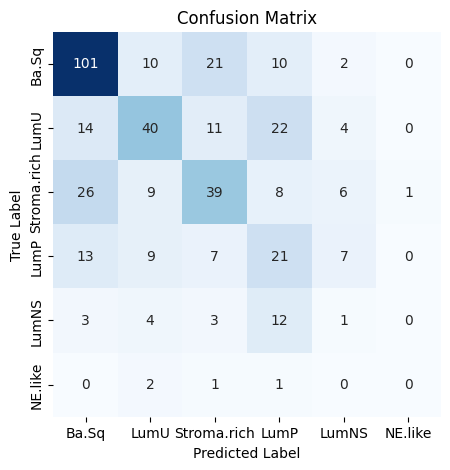

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

class_names = ['Ba.Sq', 'LumU', 'Stroma.rich', 'LumP','LumNS', 'NE.like',]
conf_matrix = confusion_matrix(
    df["target"], 
    df["prediction"],
    labels=class_names,
)
# conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(5, 5))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


In [21]:
from sklearn.metrics import classification_report

d = classification_report(df["target"], df["prediction"],  output_dict=True, zero_division=0)
d

{'Ba.Sq': {'precision': 0.610062893081761,
  'recall': 0.6736111111111112,
  'f1-score': 0.6402640264026402,
  'support': 144.0},
 'LumNS': {'precision': 0.11764705882352941,
  'recall': 0.08695652173913043,
  'f1-score': 0.09999999999999999,
  'support': 23.0},
 'LumP': {'precision': 0.24390243902439024,
  'recall': 0.17543859649122806,
  'f1-score': 0.2040816326530612,
  'support': 57.0},
 'LumU': {'precision': 0.42592592592592593,
  'recall': 0.5054945054945055,
  'f1-score': 0.4623115577889447,
  'support': 91.0},
 'NE.like': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0},
 'Stroma.rich': {'precision': 0.4444444444444444,
  'recall': 0.4044943820224719,
  'f1-score': 0.4235294117647059,
  'support': 89.0},
 'accuracy': 0.4681372549019608,
 'macro avg': {'precision': 0.30699712688334185,
  'recall': 0.3076658528097412,
  'f1-score': 0.30503110476822537,
  'support': 408.0},
 'weighted avg': {'precision': 0.44797106077431326,
  'recall': 0.4681372549019608,
  'f1-